<a href="https://colab.research.google.com/github/angeloken/Riset-I-smile/blob/main/riset_prediksi_listrik_ver_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
dfull = pd.read_excel('/content/drive/MyDrive/RISET I-SMILE/Data Device Full.xlsx')
dbar = pd.read_excel('/content/drive/MyDrive/RISET I-SMILE/Data Device Sisi Barat Gd Deli.xlsx')
dtim = pd.read_excel('/content/drive/MyDrive/RISET I-SMILE/Data Device Sisi Timur Gd Deli.xlsx')

FileNotFoundError: ignored

In [13]:
#import important library
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import date
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
url_tr = 'https://drive.google.com/file/d/1jI7ukSaRReUFAUMeH2jDMJRhRd7AnWtk/view?usp=sharing'
path_tr = 'https://drive.google.com/uc?export=download&id='+url_tr.split('/')[-2]
train = pd.read_csv(path_tr)
url_tst = 'https://drive.google.com/file/d/1Wu56Cp5qDX9gPoPk5k5_zUTmV9u27aO-/view?usp=sharing'
path_tst = 'https://drive.google.com/uc?export=download&id='+url_tst.split('/')[-2]
test = pd.read_csv(path_tst)

In [4]:
train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [5]:
train['date']=train['datetime'].str[:10]

In [6]:
train['date'] = pd.to_datetime(train['date'])

In [7]:
df = train[['date','electricity_consumption']]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     26496 non-null  datetime64[ns]
 1   electricity_consumption  26496 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 414.1 KB


In [9]:
df.set_index(df['date'],inplace=True)

In [10]:
weekly_data = df.resample('W').mean()

In [11]:
weekly_data.head()

,electricity_consumption
date,
2013-07-07,252.875000
2013-07-14,245.160714
2013-07-21,226.303571
2013-07-28,227.312500
2013-08-04,283.968750


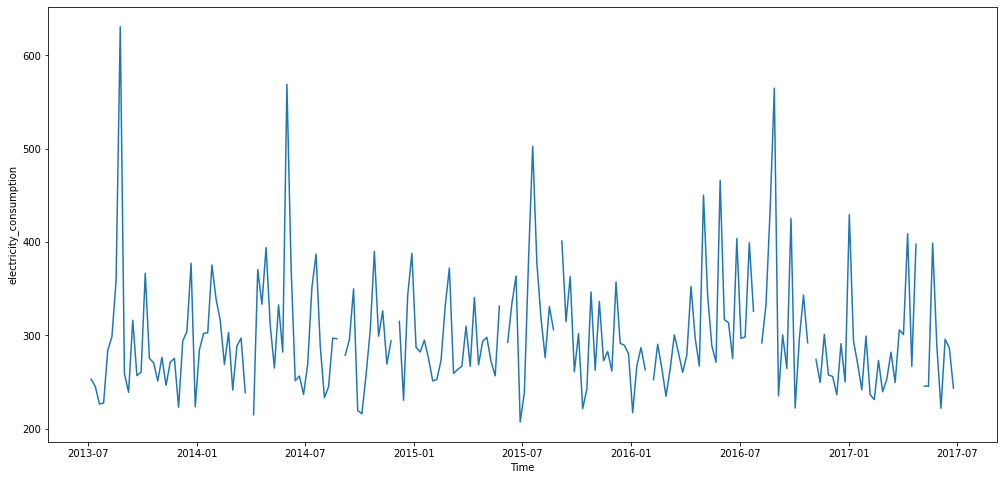

In [14]:
def plot_data(col):
    plt.figure(figsize=(17, 8))
    plt.plot(weekly_data[col])
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(False)
    plt.show()
    
for col in weekly_data.columns:
    plot_data(col)

In [15]:
df_interpolate_lin = weekly_data.interpolate(method='linear',axis=0)
df_interpolate_lin

,electricity_consumption
date,
2013-07-07,252.875000
2013-07-14,245.160714
2013-07-21,226.303571
2013-07-28,227.312500
2013-08-04,283.968750
...,...
2017-05-28,289.437500
2017-06-04,221.718750
2017-06-11,295.678571


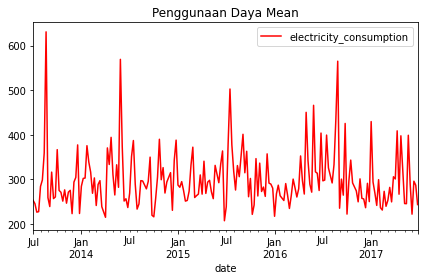

In [21]:
df_interpolate_lin.plot(title='Penggunaan Daya Mean', color='red') 
plt.tight_layout()
plt.show()

In [22]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [23]:
df = weekly_data.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2013-07-07,252.875000
1,2013-07-14,245.160714
2,2013-07-21,226.303571
3,2013-07-28,227.312500
4,2013-08-04,283.968750


In [24]:
prediction_size = 30
train_df = df[:-prediction_size]

In [25]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

In [27]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-07-07,292.828504,229.270196,369.870021,292.828504,292.828504,6.433579,6.433579,6.433579,6.433579,6.433579,6.433579,0.0,0.0,0.0,299.262083
1,2013-07-14,292.931014,272.438447,412.815690,292.931014,292.931014,47.416569,47.416569,47.416569,47.416569,47.416569,47.416569,0.0,0.0,0.0,340.347583
2,2013-07-21,293.033525,256.152194,404.349102,293.033525,293.033525,36.679530,36.679530,36.679530,36.679530,36.679530,36.679530,0.0,0.0,0.0,329.713055
3,2013-07-28,293.136036,212.302890,355.716774,293.136036,293.136036,-8.145751,-8.145751,-8.145751,-8.145751,-8.145751,-8.145751,0.0,0.0,0.0,284.990284
4,2013-08-04,293.238546,197.591778,333.151870,293.238546,293.238546,-31.133749,-31.133749,-31.133749,-31.133749,-31.133749,-31.133749,0.0,0.0,0.0,262.104797


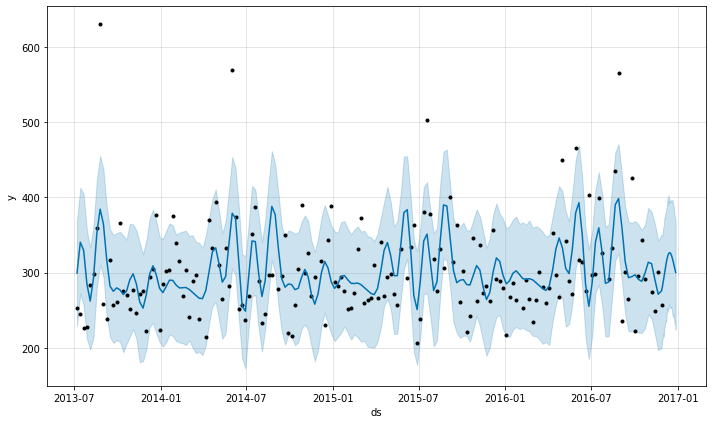

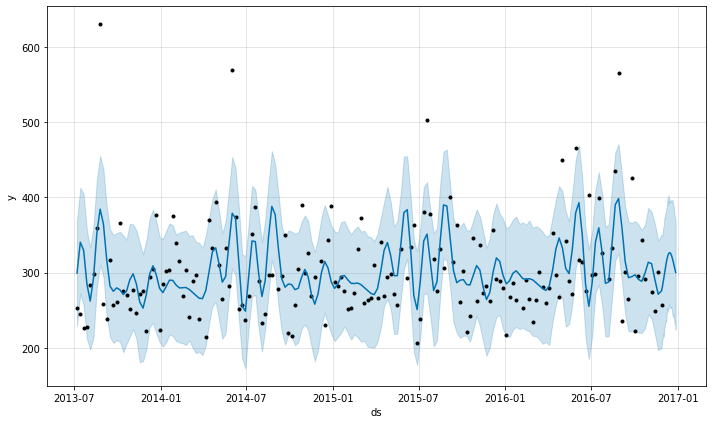

In [28]:
m.plot(forecast)

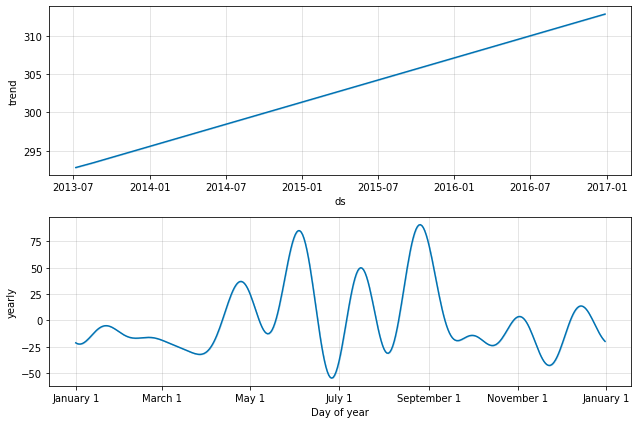

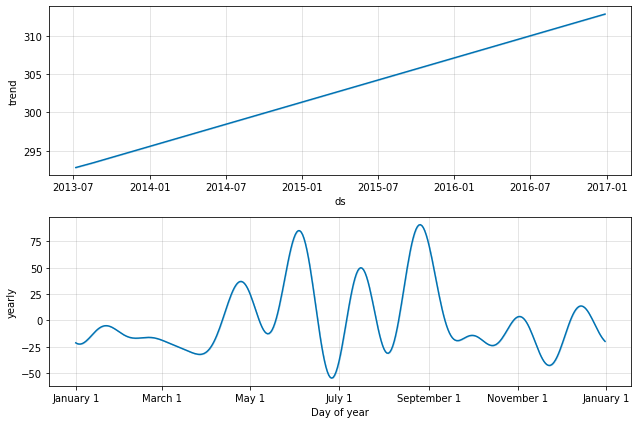

In [29]:
m.plot_components(forecast)

In [30]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [31]:
cmp_df = make_comparison_dataframe(df, forecast)

cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2013-07-07,299.262083,229.270196,369.870021,252.875000
2013-07-14,340.347583,272.438447,412.815690,245.160714
2013-07-21,329.713055,256.152194,404.349102,226.303571
2013-07-28,284.990284,212.302890,355.716774,227.312500
2013-08-04,262.104797,197.591778,333.151870,283.968750


In [32]:
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [33]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 22.004429888990252
MAE 55.1212679283556


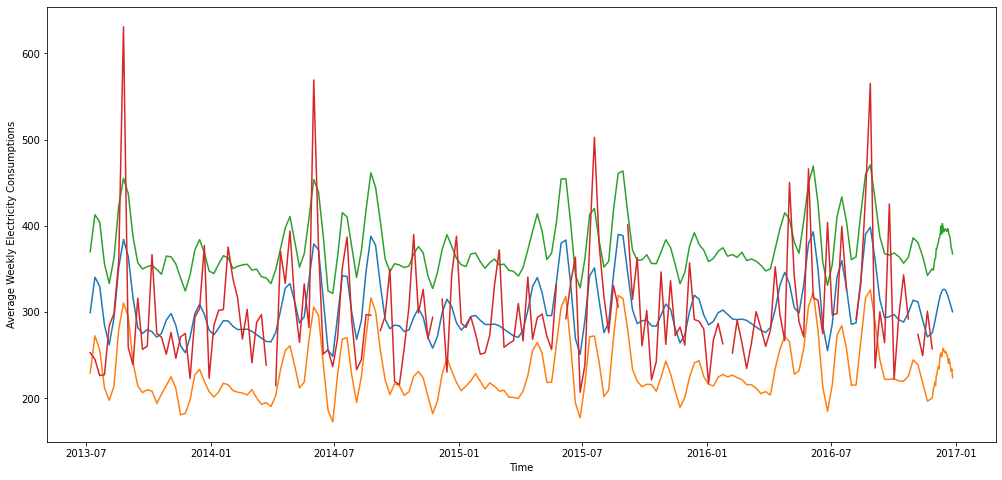

In [34]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly Electricity Consumptions')
plt.grid(False)
plt.show()